In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from scipy.sparse import linalg as spla
import spectral

Last time we talked about solving Burgers' equation. What does the matrix look like for implicit timestepping?

In [2]:
class BurgersEquationChebyshevSparse:
    
    def __init__(self, domain, u, ux, nu):
        self.u = u
        self.ux = ux
        self.domain = domain
        self.dtype = dtype = u.dtype
        self.dudx = spectral.Field(domain, dtype=dtype)
        self.u_RHS = spectral.Field(domain, dtype=dtype)
        self.ux_RHS = spectral.Field(domain, dtype=dtype)
        self.nu = nu
        
        self.problem = spectral.InitialValueProblem(domain, [u, ux], [self.u_RHS, self.ux_RHS],
                                                    num_BCs=2, dtype=dtype)
        
        p = self.problem.pencils[0]
        
        self.N = N = domain.bases[0].N
        Z = np.zeros((N, N))
        
        diag = np.arange(N-1)+1
        D = sparse.diags(diag, offsets=1)

        diag0 = np.ones(N)/2
        diag0[0] = 1
        diag2 = -np.ones(N-2)/2
        self.C = C = sparse.diags((diag0, diag2), offsets=(0,2))
        
        M = sparse.csr_matrix((2*N+2,2*N+2))
        M[N:2*N, :N] = C
        p.M = M
        
        # L matrix
        BC_rows = np.zeros((2, 2*N))
        i = np.arange(N)
        BC_rows[0, :N] = (-1)**i
        BC_rows[1, :N] = (+1)**i

        cols = np.zeros((2*N,2))
        cols[  N-1, 0] = 1
        cols[2*N-1, 1] = 1
        corner = np.zeros((2,2))

        Z = np.zeros((N, N))
        L = sparse.bmat([[D, -C],
                         [Z, -nu*D]])
        L = sparse.bmat([[      L,   cols],
                         [BC_rows, corner]])
        L = L.tocsr()
        p.L = L
        self.t = 0
        
    def evolve(self, timestepper, dt, BC_func, num_steps):
        ts = timestepper(self.problem)
        u = self.u
        ux = self.ux
        ux_RHS = self.ux_RHS

        for i in range(num_steps):
            u.require_coeff_space()
            ux.require_coeff_space()
            ux_RHS.require_coeff_space()
            
            u.require_grid_space(scales=3/2)
            ux.require_grid_space(scales=3/2)
            ux_RHS.require_grid_space(scales=3/2)
            
            ux_RHS.data = -u.data * ux.data
            ux_RHS.require_coeff_space()
            ux_RHS.data = self.C @ ux_RHS.data
            u.require_coeff_space()
            ux.require_coeff_space()
            ts.step(dt, BC_func(self.t))
            self.t += dt

In [3]:
N = 256
x_basis = spectral.Chebyshev(N)
x = x_basis.grid()
domain = spectral.Domain([x_basis])
dtype = np.float64
u = spectral.Field(domain, dtype=dtype)
ux = spectral.Field(domain, dtype=dtype)
BC_func = lambda t: [0.5*(1+np.sin(om*t)), 0]

nu = 1e-2
dt = 1e-2
t_end = 10
om = 2*np.pi
num_steps = int(t_end/dt)

burgers = BurgersEquationChebyshevSparse(domain, u, ux, nu)

C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


<IPython.core.display.Javascript object>


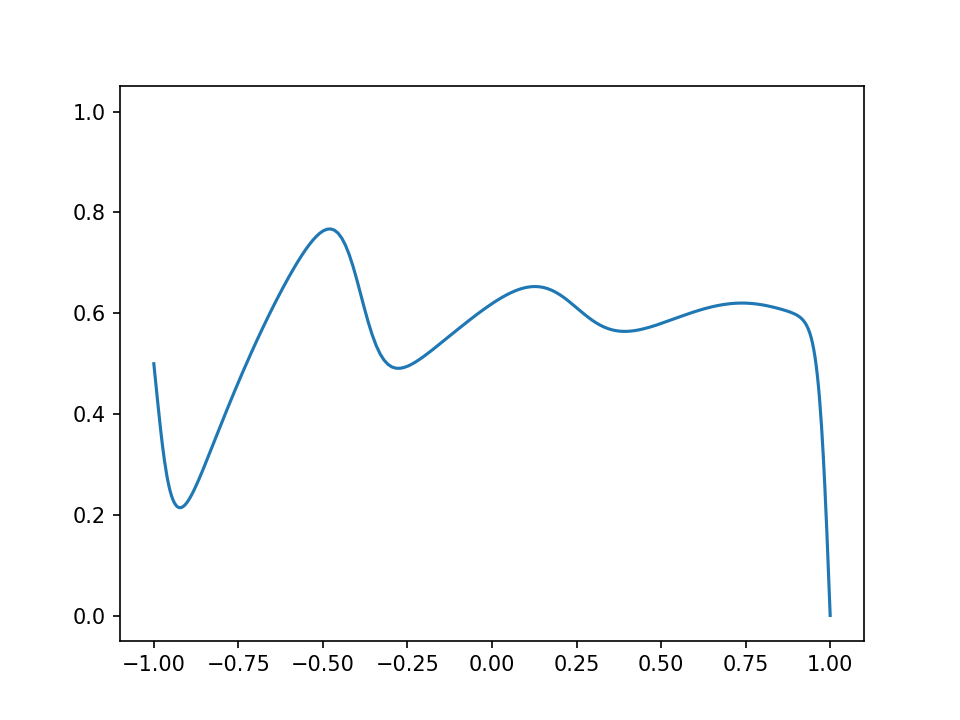

C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [4]:
fig = plt.figure()
u.require_grid_space()
p, = plt.plot(x, u.data)
fig.canvas.draw()
plt.ylim([-0.05,1.05])

for i in range(num_steps//5):
    burgers.evolve(spectral.SBDF2, dt, BC_func, 5)
    
    u.require_grid_space()
    p.set_ydata(u.data.real)
    fig.canvas.draw()

For Forward/Backward Euler, the `LHS` matrix is $M/dt + L$.

In [5]:
LHS = burgers.problem.pencils[0].M/dt + burgers.problem.pencils[0].L

<IPython.core.display.Javascript object>


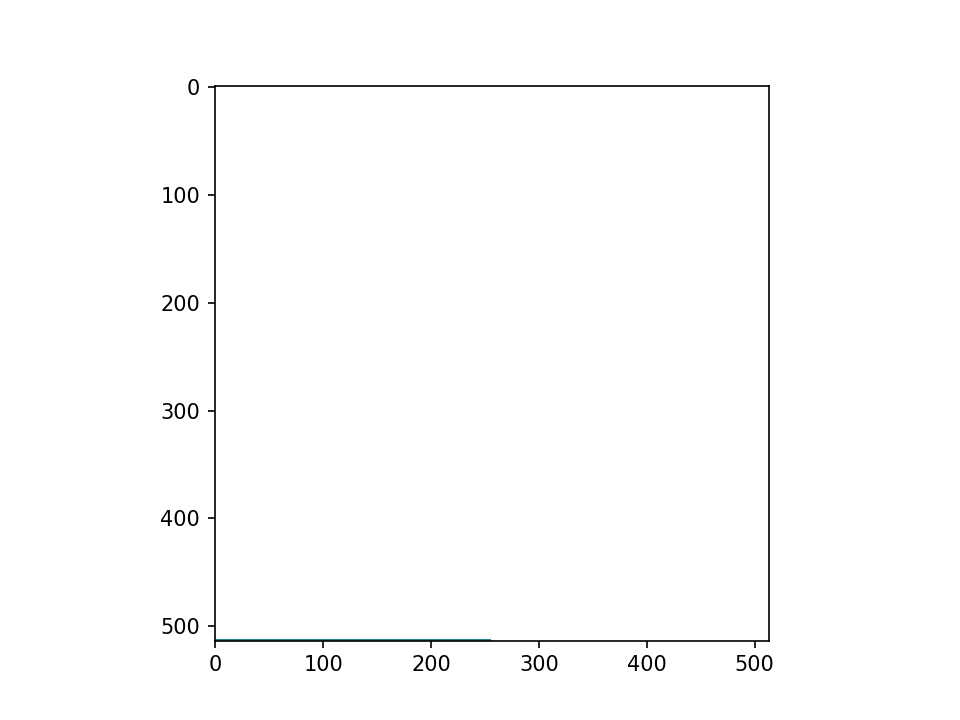

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [6]:
plt.figure()
plt.imshow(np.log(np.abs(LHS.A)))

To make the matrix more banded, we used a permutation matrix, which is calculated and stored in the `problem`.

In [7]:
P = burgers.problem.P

In [8]:
LHS_perm = P @ LHS @ P.T

<IPython.core.display.Javascript object>


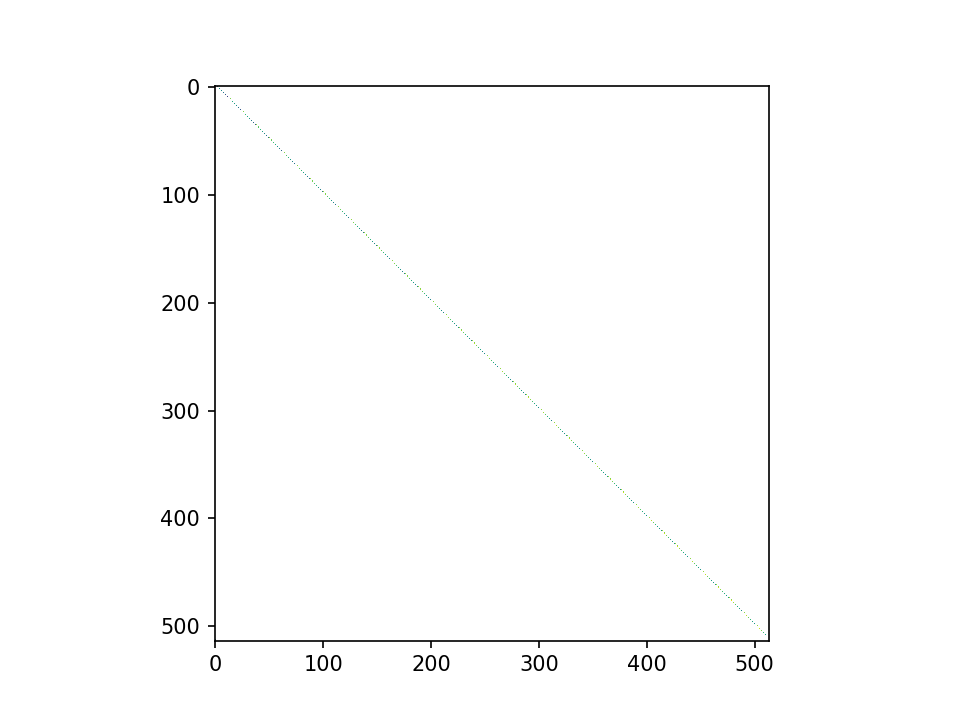

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [9]:
plt.figure()
plt.imshow(np.log(np.abs(LHS_perm.A)))

To do timestepping, we calculate the LU factorization of this matrix, and use that to backsolve. Let's look at the `L` and `U` matrices.

In [10]:
LU = spla.splu(LHS_perm)

In [11]:
LU.U

<514x514 sparse matrix of type '<class 'numpy.float64'>'
	with 15133 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


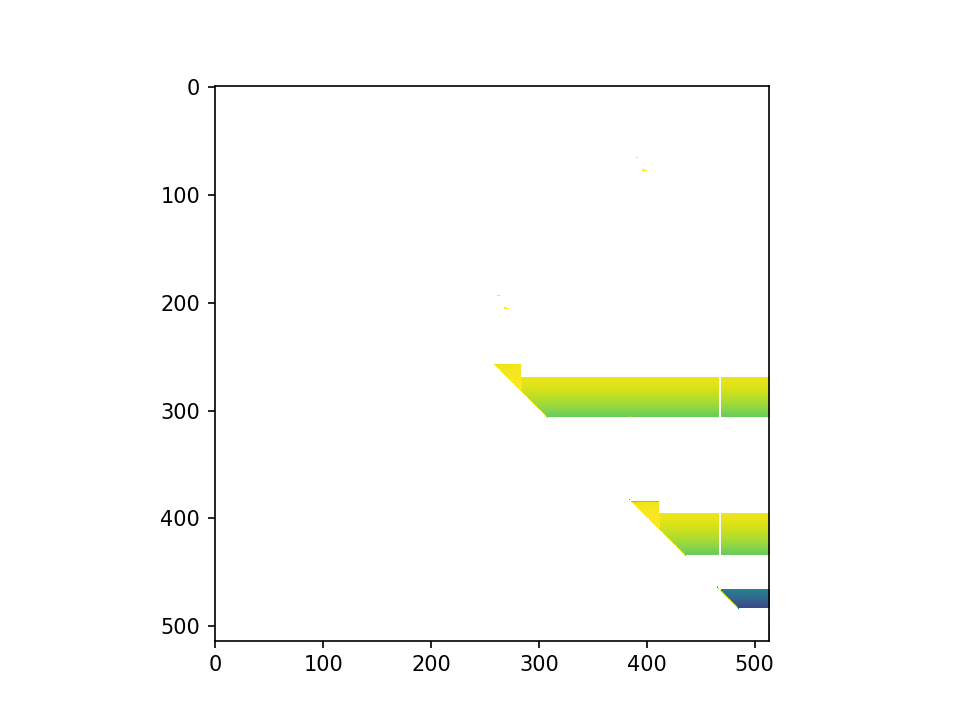

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [12]:
plt.figure()
plt.imshow(np.log(np.abs(LU.U.A)))

In [13]:
diag0 = np.ones(N)
diag2 = -np.ones(N-2)

R = sparse.diags((diag0, diag2), offsets=(0, +2))

<IPython.core.display.Javascript object>


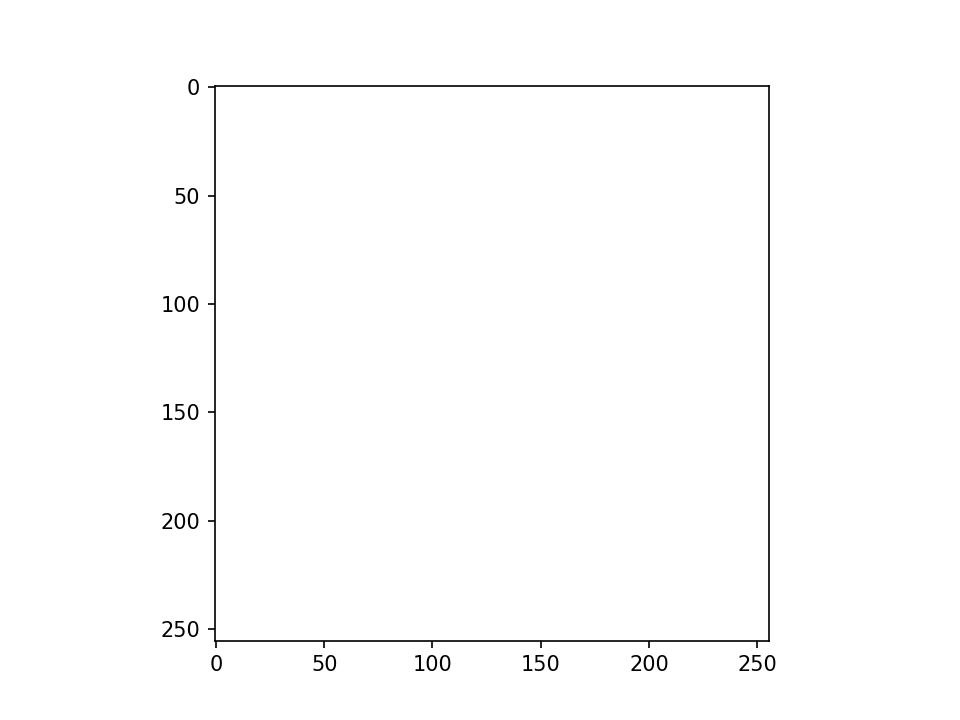

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [14]:
plt.figure()
plt.imshow(np.log(np.abs(R.A)))

In [15]:
P_R = sparse.eye(2*N+2)
P_R = P_R.tocsr()
P_R[:N, :N] = R
P_R[N:2*N, N:2*N] = R

C:\Users\siqia\Anaconda3\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


<IPython.core.display.Javascript object>


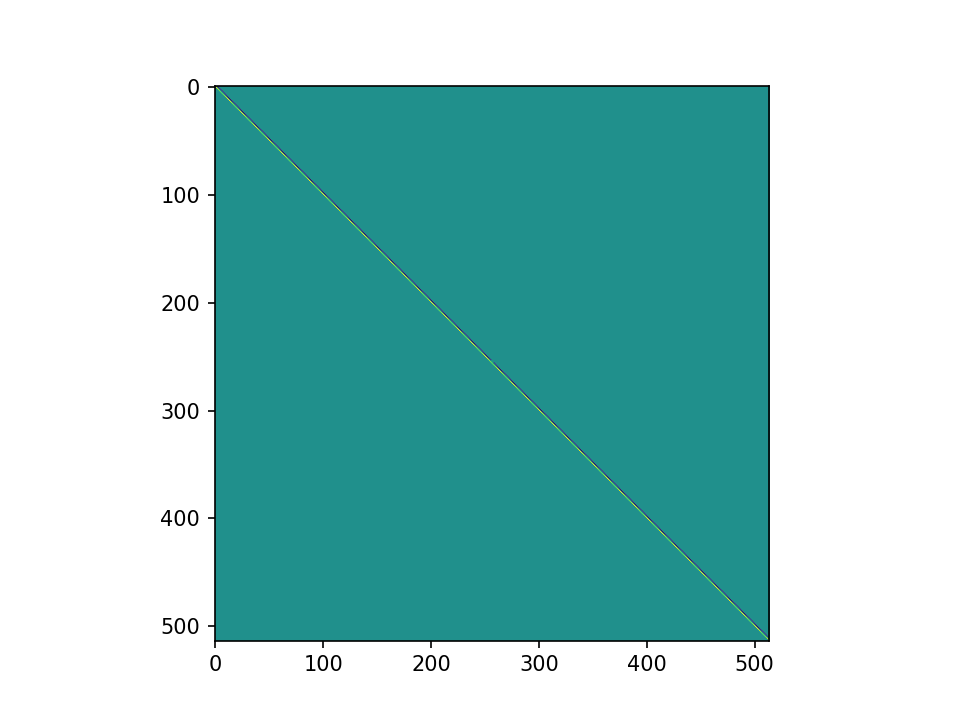

In [16]:
plt.figure()
plt.imshow(P_R.A)

In [17]:
LHS_R = P @ LHS @ P_R @ P.T

<IPython.core.display.Javascript object>


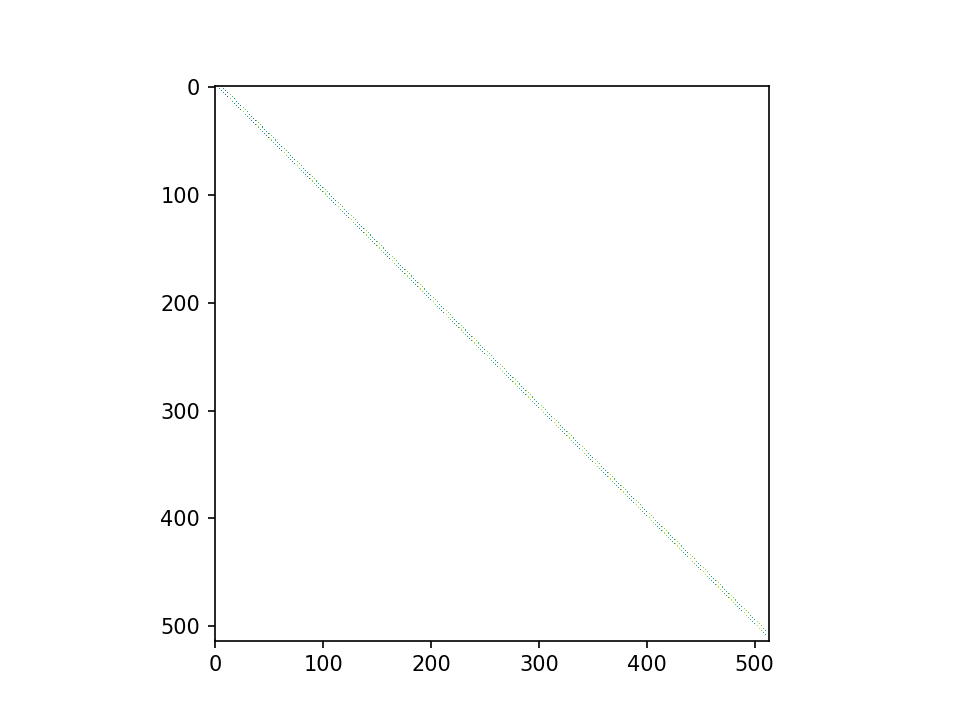

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [18]:
plt.figure()
plt.imshow(np.log(np.abs(LHS_R.A)))

In [19]:
LU = spla.splu(LHS_R)

In [20]:
LU.U

<514x514 sparse matrix of type '<class 'numpy.float64'>'
	with 2312 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


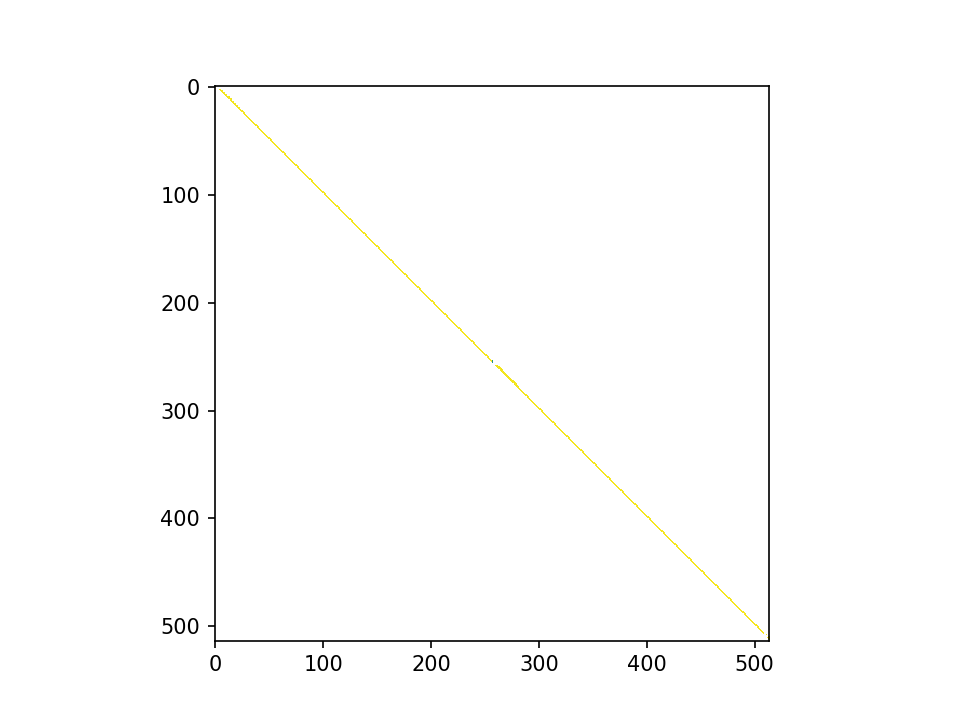

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [21]:
plt.figure()
plt.imshow(np.log(np.abs(LU.U.A)))

That was kind of complicated... let's try just transposing.

In [22]:
LHS_perm = P @ LHS @ P.T

<IPython.core.display.Javascript object>


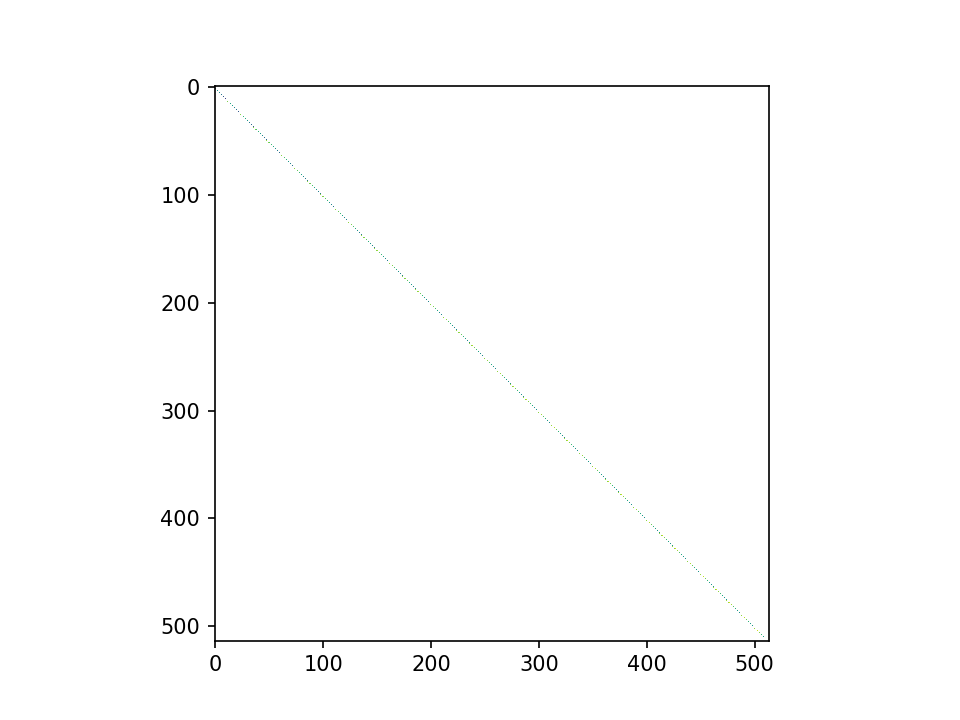

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [23]:
plt.figure()
plt.imshow(np.log(np.abs(LHS_perm.A.T)))

In [24]:
LU = spla.splu(LHS_perm.T)

In [25]:
LU.U

<514x514 sparse matrix of type '<class 'numpy.float64'>'
	with 2294 stored elements in Compressed Sparse Column format>

<IPython.core.display.Javascript object>


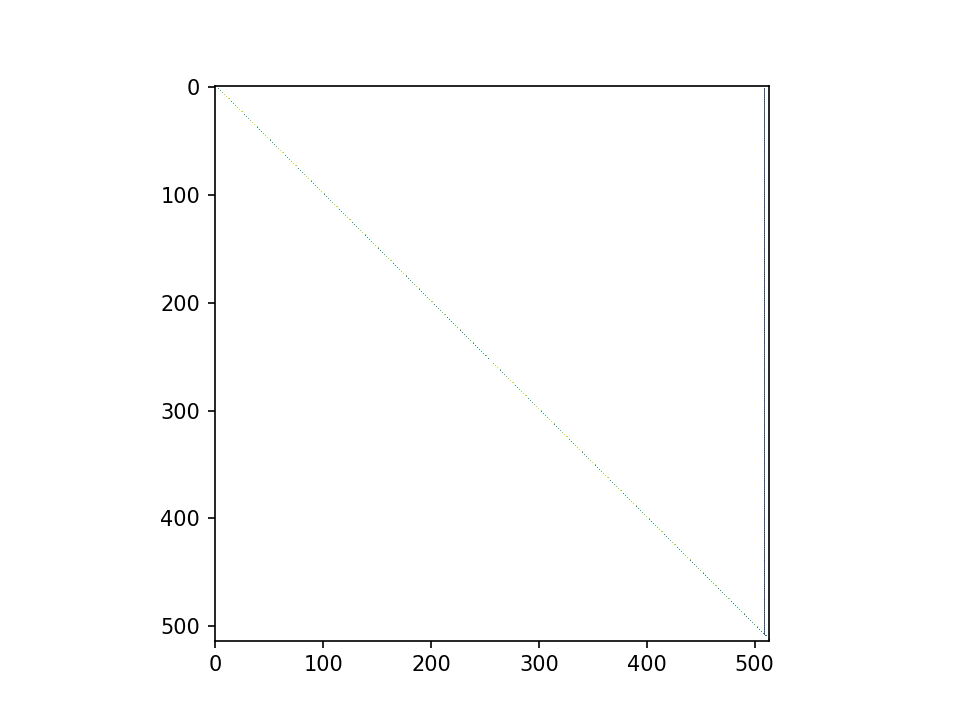

C:\Users\siqia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [26]:
plt.figure()
plt.imshow(np.log(np.abs(LU.U.A)))

## Multi-dimensional problems

Let's make a 2D function.